# Assignment 3 Report - Analysing Wellington City Property Title data
---

- Date: 2 June 2019
- Course: Introduction to Analytics 158.739, Massey University


## Section 1 - Background and overview of results
---
The purpose of this report is to describe the methodology and results of an analysis undertaken of property title data for over 55,000 properties in central and southern Wellington City.  

The property title data was accessed from Land Information New Zealand's (LINZ) data service API.  Area units, a geographic boundary type similar to suburbs, were accessed in a geospatial format from Stats NZ's 'Data Finder' API. Data from the 2013 census relating to the number of rooms per dwelling was also included in the analysis, and was downloaded in 'csv' format from Stats NZ's NZ.Stat data service. 

Some of the insights that are able to be made after exploring and analysing the data include:
* The areas with the largest number of property titles are (unsurprisingly) in the Wellington CBD.  
* There is an almost 1:1 correlation between the number of property titles in each area and the number of dwellings recorded in the 2013 census data for that area.  The main areas where this doesn't hold true are the CBD areas, which probably reflects the large number of non-dwelling buildings used as offices and work properties.  
* The property titles were issued from the 1870s and the yearly volumes clearly show the impact of some major historical events like the end of World War 1 and the Great Depression in the 1930s on the growth in properties in Wellington.  
* The majority (60%) of property titles are freehold, with unit titles representing most (30%) of the rest of the titles.  Unit titles dominate in the CBD areas however, which may be due to the number of apartment and office buildings.  
* The CBD areas had a larger number of properties with under four rooms compared to the outer suburb areas.

All the code used in the analysis is included in the report so that it is fully reproducible, with two functions for downloading the APIs defined in Appendix A. It may take several minutes to download the property title data because of the large size of the geospatial property boundary data.  The 2013 census area unit data, which could only be manually downloaded from the NZ.Stat data service, is saved with the name 'nz_census_2013_rooms_per_dwelling.csv', and has been attached to the Stream assignment.  It needs to be saved in the '../datasets/' folder to be loaded.

The datasets created and used in this analysis were saved into several different formats, including an SQL lite database for the non-geospatial property title data.  

A list of references used during the analysis is included in Appendix B. The data from LINZ is licensed under the Creative Commons Attribution 4.0 New Zealand license.  The data from Stats NZ is licensed under the Creative Commons Attribution 3.0 New Zealand. 


## Section 2 - Acquiring and preparing the data 

### 2.1 Loading modules and configuring settings
---
Before importing any data, we first need to load the various Python modules required for the analysis and set some notebook settings.  


In [4]:
# Import the Python data processing and database modules required.  
import pandas as pd
import numpy as np
from pylab import rcParams
from datetime import datetime, date, time
import requests   
import sqlite3 # used for saving the data into an SQL database
import json 
import warnings 

# Import the plotting-related modules required.  
from plotnine import *
from mizani.formatters import percent_format # used to show axis labels as percentages in several graphs

# Import geospatial and mapping related packages. 
import geopandas
import folium # this is required for the interactive leaflet maps in the dashboard.  

# Configure settings for this notebook.  
%matplotlib inline 
warnings.filterwarnings('ignore') # hide warnings from appearing in this report (for display purposes) 

### 2.2 Importing the Wellington Central property title data from the LINZ Data Service API
---
The code below calls the 'download_linz_data' function in Appendix A to import the property title data from the LINZ data service for all property titles within the bounding box specified in the 'b_box' variable.  

More information about the dataset can be found at https://data.linz.govt.nz/layer/50804-nz-property-titles/ 

In [5]:
# Specify the key parameters and then pass them to the download_linz_data function which connects to the LINZ API
api_key = "<api_key_goes_here" #My LINZ API key
layer_name = "layer-50804" #The property title layer name from LINZ
b_box = "-41.344576,174.725898,-41.261269,174.857563" # This covers Wellington City CBD and the Southern/Eastern suburbs
max_number = "60000" #Over 55,000 property titles are in the bounding box area currently. 
property_df = download_linz_data(api_key, layer_name, b_box, max_number)

# One or two rogue entries are returned from Otago (!) so they are removed. 
property_df = property_df.query('land_district == "Wellington"')

# An 'issue_year' column is created, a new 'property_area' column is calculated, and the 'spatial_extens_shared' boolean
# is converted to integer type because later processing doesn't handle boolean values.
property_df['issue_year'] = pd.to_datetime(property_df['issue_date']).dt.year
property_df['total_area'] = property_df.geometry.area
property_df['spatial_extents_shared'] = property_df.spatial_extents_shared.astype(int)
property_df.head()

,id,title_no,status,type,land_district,issue_date,guarantee_status,estate_description,number_owners,spatial_extents_shared,geometry,issue_year,total_area
0,1482131,WN54C/750,LIVE,Freehold,Wellington,1999-07-08T00:00:00,Guarantee,"Fee Simple, 1/1, Part Lot 64 Deposited Plan 11...",2,0,"(POLYGON ((174.7914892 -41.3169424333, 174.791...",1999,3.649416e-08
1,4821133,755357,LIVE,Freehold,Wellington,2019-01-29T07:01:00,Guarantee,"Fee Simple, 1/1, Lot 1 Deposited Plan 503247, ...",2,0,"(POLYGON ((174.7845420833 -41.29833945, 174.78...",2019,3.448215e-08
2,4893225,829312,LIVE,Freehold,Wellington,2019-02-11T10:01:58,Guarantee,"Fee Simple, 1/1, Lot 1 Deposited Plan 522565, ...",2,0,"(POLYGON ((174.7906625667 -41.3355906667, 174....",2019,3.282014e-08
3,4893226,829313,LIVE,Freehold,Wellington,2019-02-11T10:01:58,Guarantee,"Fee Simple, 1/1, Lot 2 Deposited Plan 522565, ...",1,0,"(POLYGON ((174.79072915 -41.3357379333, 174.79...",2019,3.295362e-08
4,4905370,842296,LIVE,Freehold,Wellington,2018-12-21T11:29:06,Guarantee,"Fee Simple, 1/1, Lot 2 Deposited Plan 525750, ...",1,1,"(POLYGON ((174.7951963167 -41.3042810833, 174....",2018,2.251289e-07


### 2.3 Importing the 2013 Census Area Unit data for Wellington from the Stats NZ Datafinder API
---
Stats NZ define a range of geographic boundaries on a yearly basis that are of use for statistical analysis and planning purposes.  At the time of the 2013 census, the area unit classification was the boundary type that was closest to the concept of suburbs in cities (although area units have subsequently been replaced by the 'Statistical Area 2' classification since 2018).  

There were over 2,000 area units defined for all of New Zealand, although only the area unit boundaries for central and southern Wellington are downloaded for this analysis.  They are required so that we can determine which area unit each property title relates to so that we can aggregate the data where necessary to identify different trends in different suburbs of Wellington.   

More information about the dataset can be found at https://datafinder.stats.govt.nz/layer/25743-area-unit-2013/

In [6]:
# Specify the key parameters and then pass them to the download_stats_boundaries function which connects to the Stats API
api_key = "<stats datafinder api key" #My Stats Datafinder API key
layer_name = "layer-25743" #The property title layer name from Stats
b_box = "5421553.239,1744394.958,5430574.653,1755609.039" # Note this is in NZTM format (not lat/long)
max_number = "100" #there are only 54 area units covering the area in the boundary box so 100 is easily enough. 

area_unit_df = download_stats_boundaries(api_key, layer_name, b_box, max_number)

# Two of the area units are entirely at sea so they can be removed, as can the 'Pencarrow' area unit which is part of the Hutt. 
area_unit_df = area_unit_df.query('LAND_AREA_SQ_KM != 0 & AU2013_V1_00_NAME != "Pencarrow"')
area_unit_df.head()

,id,AU2013_V1_00,AU2013_V1_00_NAME,AREA_SQ_KM,LAND_AREA_SQ_KM,Shape_Length,Shape_Area,geometry
1,layer-25743.367,575400,Taitville,0.153277,0.153277,2082.709766,1.532902e+05,(POLYGON ((174.7601876004927 -41.2904867227488...
2,layer-25743.368,575702,Vogeltown,0.269954,0.269954,2513.520400,2.700193e+05,(POLYGON ((174.7709764833378 -41.3103578898100...
3,layer-25743.369,576301,Newtown West,0.660912,0.660912,3925.121852,6.609096e+05,(POLYGON ((174.7779147824087 -41.3072647564163...
4,layer-25743.370,576903,Kilbirnie West-Hataitai South,0.918857,0.918857,7224.151714,9.188775e+05,(POLYGON ((174.7974994161986 -41.3062163400052...
6,layer-25743.372,577500,Seatoun,1.326926,1.326926,9468.458658,1.326879e+06,(POLYGON ((174.8304823172729 -41.3186953397539...


### 2.4 Importing the 'Rooms per dwelling' 2013 census results from Stats NZ NZ.Stat website
---
The  2013 census 'Rooms per Dwelling' data for the area units in the Wellington City Territorial Authority were downloaded from the NZ.Stats website (http://nzdotstat.stats.govt.nz/wbos/Index.aspx?DataSetCode=TABLECODE8098 ).  The website unfortunately doesn't provide API or even direct data download links, so I had to manually export the file in csv format and save it to the ../datasets/ folder with the name 'nz_census_2013_rooms_per_dwelling.csv'.  It has been attached to Stream with this submission for reproducibility.    

The data was provided in a 'long' format so the code below imports it and turns it into a wide format, to assist with merging with the other two dataframes in Section 3.

In [7]:
#Import the data and drop unnecessary columns and the Wellington City overall values.
au_rooms_df_long = (pd.read_csv("../datasets/nz_census_2013_rooms_per_dwelling.csv")
                         .drop(['Flags', 'Year'], axis=1) #drop these columns that aren't required.
                         .query('Area != "Wellington City"')) #drop the the overall Wellington City TA row

# Convert the data into a wide format so that merging with other data later is easier.  
au_rooms_df = au_rooms_df_long.pivot_table(au_rooms_df_long, index='Area', columns='Number of rooms')
au_rooms_df.columns = au_rooms_df.columns.droplevel(0) #get rid of the multi-index for columns
au_rooms_df = au_rooms_df.reset_index() #reset the row index
del au_rooms_df.columns.name #removes the column index name, which was created by the pivot_table function

# Rearrange the column order into a sensible order
col_names_sorted = ['Area', 'One room', 'Two rooms', 'Three rooms', 'Four rooms', 'Five rooms', 'Six rooms', 'Seven rooms', \
               'Eight or more rooms', 'Total dwellings stated', 'Not elsewhere included', 'Total dwellings, number of rooms']
au_rooms_df = au_rooms_df[col_names_sorted]
au_rooms_df.head()

,Area,One room,Two rooms,Three rooms,Four rooms,Five rooms,Six rooms,Seven rooms,Eight or more rooms,Total dwellings stated,Not elsewhere included,"Total dwellings, number of rooms"
0,Adelaide,3.0,6.0,48.0,54.0,69.0,57.0,18.0,27.0,285.0,18.0,303.0
1,Aro Street-Nairn Street,42.0,78.0,231.0,249.0,225.0,237.0,120.0,99.0,1284.0,96.0,1377.0
2,Awarua,0.0,6.0,30.0,90.0,153.0,264.0,225.0,393.0,1164.0,27.0,1191.0
3,Berhampore East,0.0,9.0,48.0,108.0,84.0,72.0,39.0,27.0,384.0,36.0,417.0
4,Berhampore West,12.0,24.0,138.0,216.0,216.0,195.0,66.0,66.0,933.0,72.0,1008.0


## Section 3 - Integrating and saving the data into several formats

### 3.1 Merging the area unit dataframes and calculating each property title's area unit
---
Before undertaken further analysis, the two area unit dataframes 'area_unit_df' and 'au_rooms_df' need to be joined using the Pandas merge function.

The area unit for each property title also has to be calculated, and this is done using GeoPandas 'sjoin' spatial function to identify which area units each property title intersects with.  Some property titles intersect multiple area units, so the code below drops duplicates and retains the first area unit identified.  


In [8]:
# Merge the two area unit dataframes using the standard Pandas merge
full_au_df = pd.merge(area_unit_df, au_rooms_df, left_on='AU2013_V1_00_NAME', right_on='Area')
full_au_df = full_au_df.drop('AU2013_V1_00_NAME', axis=1) #Only one area name column is required.
full_au_df.head()

# Merge the area unit id, name and geometry columns from the full_au_df file into the property_title df 
# using the GeoPandas geospatial 'intersects' join.  
property_with_au_df = geopandas.sjoin(property_df, full_au_df[['AU2013_V1_00','Area','geometry']], how="left", op="intersects")

# Remove those parcels that don't have a matching area unit (e.g. those in Pencarrow), and then 
# drop some duplicate rows generated by the 'intersects' spatial join when property titles overlap.
property_with_au_df = property_with_au_df[property_with_au_df['Area'].notnull()]
property_with_au_df.drop_duplicates(subset="id", keep="first", inplace=True)
property_with_au_df.head()

,id,title_no,status,type,land_district,issue_date,guarantee_status,estate_description,number_owners,spatial_extents_shared,geometry,issue_year,total_area,index_right,AU2013_V1_00,Area
0,1482131,WN54C/750,LIVE,Freehold,Wellington,1999-07-08T00:00:00,Guarantee,"Fee Simple, 1/1, Part Lot 64 Deposited Plan 11...",2,0,"(POLYGON ((174.7914892 -41.3169424333, 174.791...",1999,3.649416e-08,3.0,576903,Kilbirnie West-Hataitai South
1,4821133,755357,LIVE,Freehold,Wellington,2019-01-29T07:01:00,Guarantee,"Fee Simple, 1/1, Lot 1 Deposited Plan 503247, ...",2,0,"(POLYGON ((174.7845420833 -41.29833945, 174.78...",2019,3.448215e-08,12.0,573400,Mt Victoria West
2,4893225,829312,LIVE,Freehold,Wellington,2019-02-11T10:01:58,Guarantee,"Fee Simple, 1/1, Lot 1 Deposited Plan 522565, ...",2,0,"(POLYGON ((174.7906625667 -41.3355906667, 174....",2019,3.282014e-08,37.0,576100,Melrose-Houghton Bay-Southgate
3,4893226,829313,LIVE,Freehold,Wellington,2019-02-11T10:01:58,Guarantee,"Fee Simple, 1/1, Lot 2 Deposited Plan 522565, ...",1,0,"(POLYGON ((174.79072915 -41.3357379333, 174.79...",2019,3.295362e-08,37.0,576100,Melrose-Houghton Bay-Southgate
4,4905370,842296,LIVE,Freehold,Wellington,2018-12-21T11:29:06,Guarantee,"Fee Simple, 1/1, Lot 2 Deposited Plan 525750, ...",1,1,"(POLYGON ((174.7951963167 -41.3042810833, 174....",2018,2.251289e-07,40.0,576800,Hataitai North


### 3.2 Saving the geospatial data as geoJSON files
---
The geospatial data in both of the dataframes that have been prepared for analysis ('full_au_df' and 'property_with_au_df') are best saved to disk in formats specifically designed for storing geospatial data efficiently. 

The code below saves both dataframes as geoJSON files in the '../datsets' folder.  

In [9]:
# Note that saving the property data takes up to one minute because of its size (58MB) 
full_au_df.to_file("../datasets/full_au_df.geojson", driver='GeoJSON')
property_with_au_df.to_file("../datasets/property_with_au_df.geojson", driver='GeoJSON')

### 3.3 Saving the non-spatial property data in an SQL lite database 
---
The non-geometry columns of the property_with_au_df are saved in an .sl3 SQL lite database file in the '../datasets' folder.  Even without the geometry data the file is still 11MB because it has over 55,000 rows.  

In [10]:
# Create the connection to the 'property_non_spatial_df.sl3', drops the 'property_titles' table if it exists, 
# and creates a new one.
connection = sqlite3.connect('../datasets/property_non_spatial_df.sl3')
cursor = connection.cursor()
creation_sql = """
    CREATE TABLE property_titles (
      row_id INTEGER PRIMARY KEY,
      id INTEGER,
      title_no TEXT,
      status TEXT,
      type TEXT,
      land_district TEXT,
      issue_date DATE,
      guarantee_status TEXT,
      estate_description TEXT,
      number_owners INTEGER,
      spatial_extents_shared INTEGER,
      issue_year INTEGER,
      total_area REAL,
      index_right REAL,
      AU2013_V1_00 TEXT,
      Area TEXT      
    ) 
    """

# Executes the SQL above and commits it.
cursor.execute("DROP TABLE IF EXISTS property_titles")
cursor.execute(creation_sql)
connection.commit()

# load the property_with_au_df data into the SQL database after dropping the geometry data
property_with_au_df.drop('geometry', axis=1).to_sql('property_titles', con=connection, if_exists='replace')

# Close the connection
cursor.close()
connection.close()

### 3.4 Saving the non-spatial area and property unit data as CSV files
---
The non-geometry columns of the full_au_df file and property_with_au_df file are saved as a 'csv' file 
in the ../datasets/ folder.  These are also uploaded to Stream with this assignment. 

In [11]:
# Save the property_with_au_df and full_au_df data as csv files after dropping the geometry data
full_au_df.drop('geometry', axis=1).to_csv("../datasets/full_area_unit_data.csv")
property_with_au_df.drop('geometry', axis=1).to_csv("../datasets/property_with_au_df.csv")

## Section 4 - Exploring and analysing the data with maps

### 4.1 Overall plot of the data
---
Maps can be an appealing visualisation but they are also very useful with validating that the data you have acquired is reasonable and is for the area of interest.  The map below shows over 55,000 property titles in red, with the area units in black.   

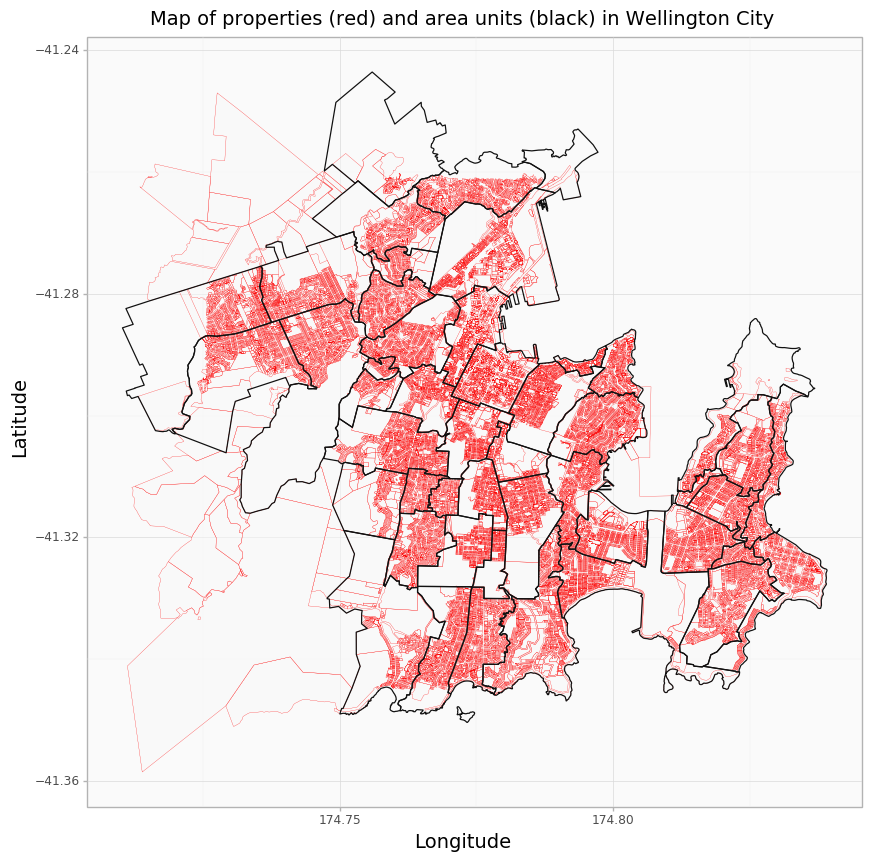

<ggplot: (164472497770)>

In [12]:
# Create a map showing all the area units and property boundaries contained in the data.  The area unit for 
# Makara is dropped because it is huge and makes it hard to see the others.  
(ggplot() 
 + geom_map(data=property_with_au_df, fill="#f9f9f9", color="red", size=0.1, alpha=0.5)
 + geom_map(data=full_au_df.query('AREA_SQ_KM < 100'), fill=None, size=0.5, alpha=0.8) 
 + theme_light()
 + theme(panel_background=element_rect(fill="#f9f9f9", alpha=0.8), figure_size=(10, 10), 
         title=element_text(size=14))
 + labs(x="Longitude", y="Latitude", title="Map of properties (red) and area units (black) in Wellington City")
)
 

### 4.2 Thematic map to show year of property title issue
---
The chloropleth map below uses colouring to show the year that each title was issued for properties on the Miramar Peninsula, to the east of Wellington Airport.  The map shows that a large number of properties throughout the peninsula had titles issued prior to the 1940s.  The main exception is the suburb of Strathmore Park, and this is clearly evident in the Southern portion of the map.  

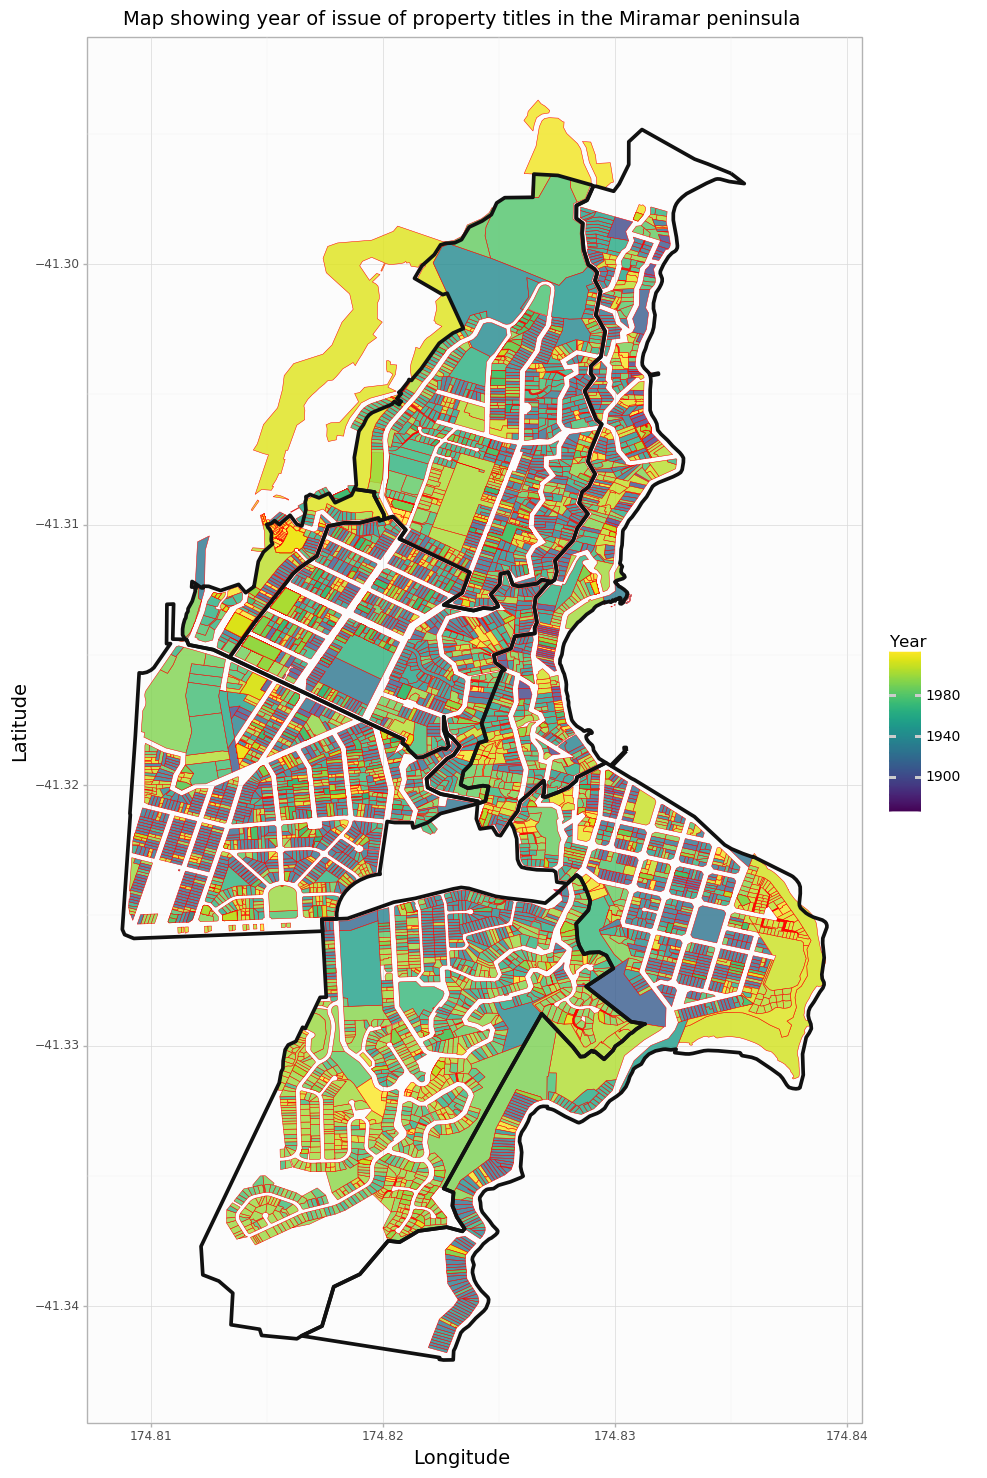

<ggplot: (-9223371872380629546)>

In [13]:
# Create a chloropleth map of the area units and properties in the Miramar Peninsula, with coloring for year of title issue.
query_text = 'Area=="Miramar North" | Area=="Miramar West" | Area=="Miramar" | Area=="Miramar South" | Area=="Strathmore Park" | Area=="Seatoun" | Area=="Karaka Bay-Worser Bay"'
(ggplot() 
 + geom_map(property_with_au_df.query(query_text), 
            aes(fill='issue_year'), alpha=0.8, color="red", size=0.2)
 + geom_map(data=full_au_df.query(query_text), fill=None, size=1.5, alpha=0.8) 
 + theme_light()
 + theme(panel_background=element_rect(fill="#fcfcfc", alpha=0.9), title=element_text(size=14), figure_size=(10, 18),
         legend_text=element_text(size=10), legend_title=element_text(size=12), legend_position="right")
 + labs(x="Longitude", y="Latitude", title="Map showing year of issue of property titles in the Miramar peninsula",
       fill="Year")
) 

### 4.3 Interactive mapping to show all the property titles issued in the 1900s
---
Interactive mapping is a particularly useful tool for exploratory analysis, because it allows users to zoom in and out of the detail as required.  The interactive chloropleth map below, using the Folium package, displays all the properties with titles issued prior to 1900, and shades them according to year.  It clearly indicates that the oldest properties tend to cluster in the inner city suburbs of Newtown, Mount Victoria, Thorndon, Mt Cook and Te Aro.

In [14]:
# converts the dataframes to json because folium requires them in this format. 
# Also filters properties to those with titles issued pre 1900 
au_df_geojson = full_au_df.to_json()
subset_df = property_with_au_df.query('issue_year<1900')
subset_df_geojson = subset_df.to_json()
                                      
interactive_map = folium.Map([-41.3, 174.8],
                  zoom_start=13,
                  tiles='cartodbpositron')

folium.Choropleth(
    geo_data=au_df_geojson,
    line_color='purple',
    fill_color='None',
    fill_opacity=1,
    line_weight=2).add_to(interactive_map)

folium.Choropleth(geo_data=subset_df_geojson, 
                  data=subset_df, 
                  line_color='black',
                  line_weight=1, 
                  columns=['id', 'issue_year'], 
                  fill_color='YlOrRd',
                  name='choropleth', fill_opacity=0.7, line_opacity=0.5, key_on='feature.properties.id',
                  legend_name='issue_year').add_to(interactive_map)
interactive_map

## Section 5 - Exploring and analysing the data with plots and tables

### 5.1 When were most property titles issued?
---
The bar plot below shows the yearly number of property titles issued in Wellington. Some periods of strong growth and marked decline are quite evident in the data, particularly with the onset of the Great Depression in 1931.  The large number of property titles issued from the mid 1990s is of interest, and is discussed further in section 5.3.  

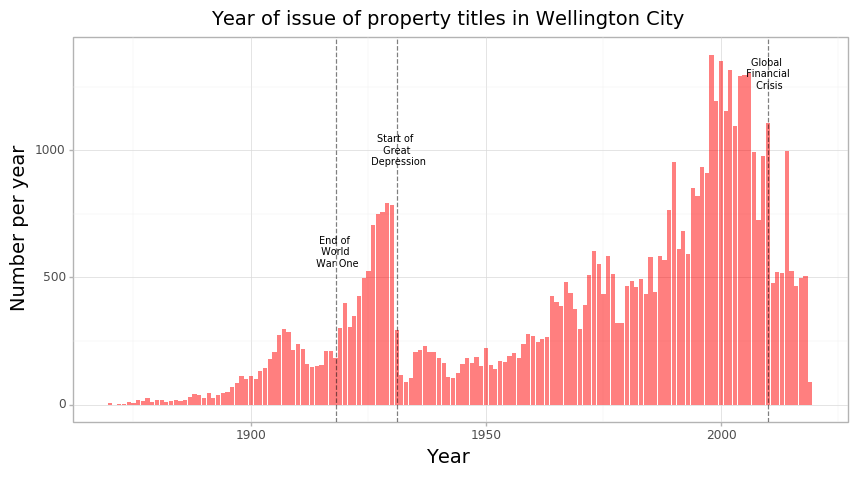

<ggplot: (-9223371872380992007)>

In [15]:
(ggplot(property_with_au_df, aes('issue_year')) 
 + geom_bar(fill="red", alpha=0.5)  #p9.scale_y_log10() +
 + theme_light() 
 + theme(title=element_text(size=14), figure_size=(10, 5),
         legend_text=element_text(size=10), legend_title=element_text(size=12), legend_position="right")
 + labs(x="Year", y="Number per year", title="Year of issue of property titles in Wellington City",
       fill="Year")
 + geom_vline(xintercept = 1931, linetype='dashed', alpha=0.5)  
 + annotate("text",x=1931, y=1000, label="Start of \n Great \n Depression", size=7)
 + geom_vline(xintercept = 1918, linetype='dashed', alpha=0.5)
 + annotate("text",x=1918, y=600, label="End of \n World \n War One", size=7)
 + geom_vline(xintercept = 2010, linetype='dashed', alpha=0.5)
 + annotate("text",x=2010, y=1300, label="Global \n Financial \n Crisis", size=7)
)

### 5.2 Which areas have the most properties and when were the titles issued?
---
The groupby function in Pandas allows an 'area_unit_totals' dataframe to be created showing summary statistics from the property title data for each area.  The three areas in Wellington CBD clearly have the most property titles, and both the Willis Street and Lambton areas have very recent median issue years.  

Another summary table 'area_unit_totals_per_year' was calculated and plotted to show how the year that property titles issued per area unit can vary substantially. The plot shows that urban areas with lots of apartments and offices appear to have had a lot of development in recent decades.  Newish suburbs that were built in the 1960s and 1970s such as Maupuia, Strathmore Park and Wilton, contrast sharply with the older suburbs like Newtown and Mount Victoria with properties issued over a much longer period.  

In [16]:
# Use the groupby function to count the number of unique property titles per area unit, and calculate the median issue year and 
# mean number of property owners.  
area_unit_totals = (property_with_au_df
                    .groupby(['AU2013_V1_00','Area'], as_index=False)
                    .agg({'id':'count', 'issue_year':'median', 'number_owners': 'mean'})
                    .rename(index=str, columns={'id':'total_properties', 'issue_year':'median_issue_year', \
                                               'number_owners':'mean_number_owners'})
                    .sort_values(by=['total_properties'], ascending=False))
area_unit_totals.head()


,AU2013_V1_00,Area,total_properties,median_issue_year,mean_number_owners
2,573101,Willis Street-Cambridge Terrace,6679,2005.0,1.531217
1,573000,Lambton,4731,2003.0,1.392729
0,572900,Thorndon-Tinakori Road,2936,1994.0,1.665872
5,573400,Mt Victoria West,2323,1984.0,1.641842
4,573300,Mt Cook-Wallace Street,1851,1999.0,1.492707


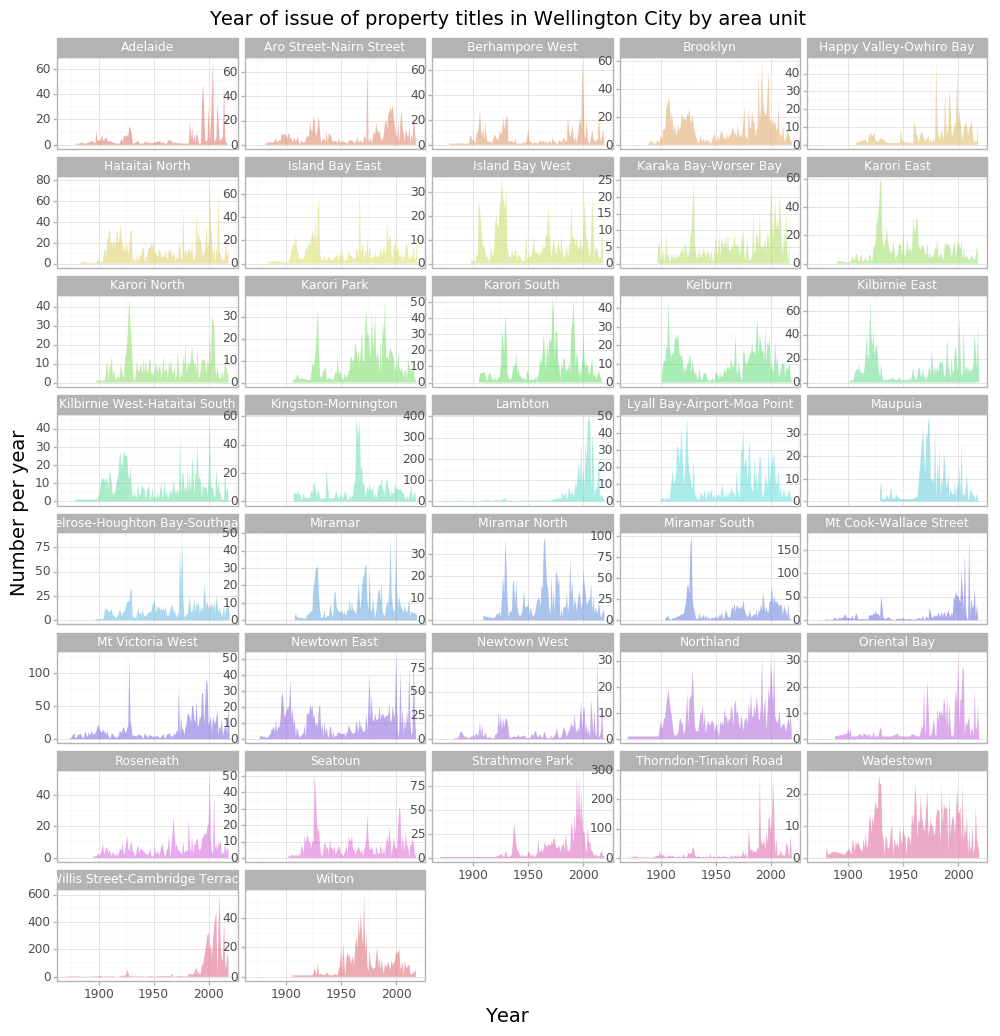

<ggplot: (164473508886)>

In [17]:
# Use the groupby function to count the number of property titles issued per year for each area unit.   
area_unit_totals_per_year = (property_with_au_df
                    .groupby(['AU2013_V1_00','Area', 'issue_year'], as_index=False)
                    .agg({'id':'count'})
                    .rename(index=str, columns={'id':'total_properties'}))

# Get the names of the area units with over 500 properties, so we can graph them. 
larger_area_units = area_unit_totals.query('total_properties>500')['Area']

# Plot the yearly number of property titles issued in the area units with over 500 properties
(ggplot(area_unit_totals_per_year[area_unit_totals_per_year['Area'].isin(larger_area_units)], \
        aes('issue_year', 'total_properties',fill='Area')) 
 + geom_area(alpha=0.5)  
 + theme_light() 
 + scale_fill_discrete(guide=False)
 + facet_wrap(facets=('Area'), scales="free_y", nrow=10, ncol=5)
 + theme(title=element_text(size=14), figure_size=(12, 12),
         legend_text=element_text(size=10), legend_title=element_text(size=12), legend_position="bottom")
 + labs(x="Year", y="Number per year", title="Year of issue of property titles in Wellington City by area unit",
       fill="Year")
)

### 5.3 Are the number of census dwellings and property titles similar?
---
The scatter plot below compares the number of property titles in each area unit and the number of dwellings reported in the census data.  It reassuringly shows that there is an almost 1:1 correlation between the data, which is a very good sign given that both datasets are completely independent. The main areas where the correlation doesn't hold true are the CBD areas, which probably reflects the large number of non-dwelling properties such as office buildings and retail shops. Crofton Downs and Makara-Ohariu show low numbers of property titles because the bounding box used to selec the data cut through both these area units.    

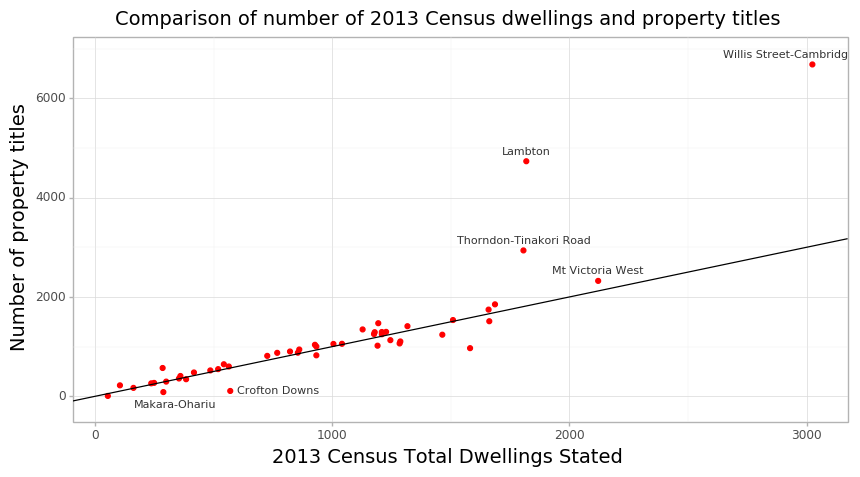

<ggplot: (-9223371872381844038)>

In [18]:
# Merge the area_unit_totals dataframe with the full_au_df area unit dataframe
area_unit_totals_merged = pd.merge(area_unit_totals, full_au_df)

# Plot the number of 2013 census dwellings vs the number of property titles per area unit
(ggplot(area_unit_totals_merged, aes('Total dwellings stated', 'total_properties')) 
 + geom_point(alpha=1, color='red')  #p9.scale_y_log10() +
 + theme_light() 
 + scale_color_discrete(guide=False)
 + geom_text(aes(label='Area'), data=area_unit_totals_merged.query('total_properties>2000'),size=8, nudge_y=200, alpha=0.8)
 + geom_text(aes(label='Area'), data=area_unit_totals_merged.query('Area=="Crofton Downs"'),size=8, nudge_y=0, 
             nudge_x=200,alpha=0.8)
 + geom_text(aes(label='Area'), data=area_unit_totals_merged.query('Area=="Makara-Ohariu"'),size=8, nudge_y=-250, alpha=0.8,
            nudge_x=50)
 + geom_abline()
 + theme(title=element_text(size=14), figure_size=(10, 5),
         legend_text=element_text(size=10), legend_title=element_text(size=12), legend_position="bottom")
 + labs(x="2013 Census Total Dwellings Stated", y="Number of property titles", 
        title="Comparison of number of 2013 Census dwellings and property titles",
       fill="Year")
)

### 5.4 What types of property titles are there, and does the mix vary by area?
---
The summary table below was calculated to identify the most common types of property titles in Wellington City.  Freehold titles are clearly the majority (60%), and unit titles represent almost a third of the titles.  

The bar plot shows the number of each type of property title by area unit. Freehold titles are the most common in the suburbs, but unit titles dominate in the CBD areas, which may be due to the number of apartments and office buildings.  This would explain why the median issue year of unit titles is much more reent than freehold titles.

In [20]:
# Use the groupby function to count the number of each property title type and show other summary info.    
property_title_type_summary = (property_with_au_df
                    .groupby(['type'], as_index=False)
                    .agg({'id':'count', 'issue_year':'median', 'number_owners': 'mean'})
                    .rename(index=str, columns={'id':'total_properties', 'issue_year':'median_issue_year', \
                                               'number_owners':'mean_number_owners'})
                    .sort_values(by=['total_properties'], ascending=False))
property_title_type_summary['proportion'] = (property_title_type_summary['total_properties']/sum(property_title_type_summary['total_properties']))
property_title_type_summary.head(10)

,type,total_properties,median_issue_year,mean_number_owners,proportion
1,Freehold,33480,1961.0,1.742204,0.600764
8,Unit Title,16912,2003.0,1.588990,0.303469
0,Cross lease,2299,1987.0,1.584602,0.041253
3,Leasehold,1322,2003.0,1.299546,0.023722
6,Supplementary Record Sheet,1267,1996.0,0.000000,0.022735
5,Records Embodied in the Register,307,2009.0,1.547231,0.005509
4,Life Estate,88,2010.5,2.375000,0.001579
2,Gazette Notice,53,2010.0,1.000000,0.000951
7,Timeshare,1,1996.0,1.000000,0.000018


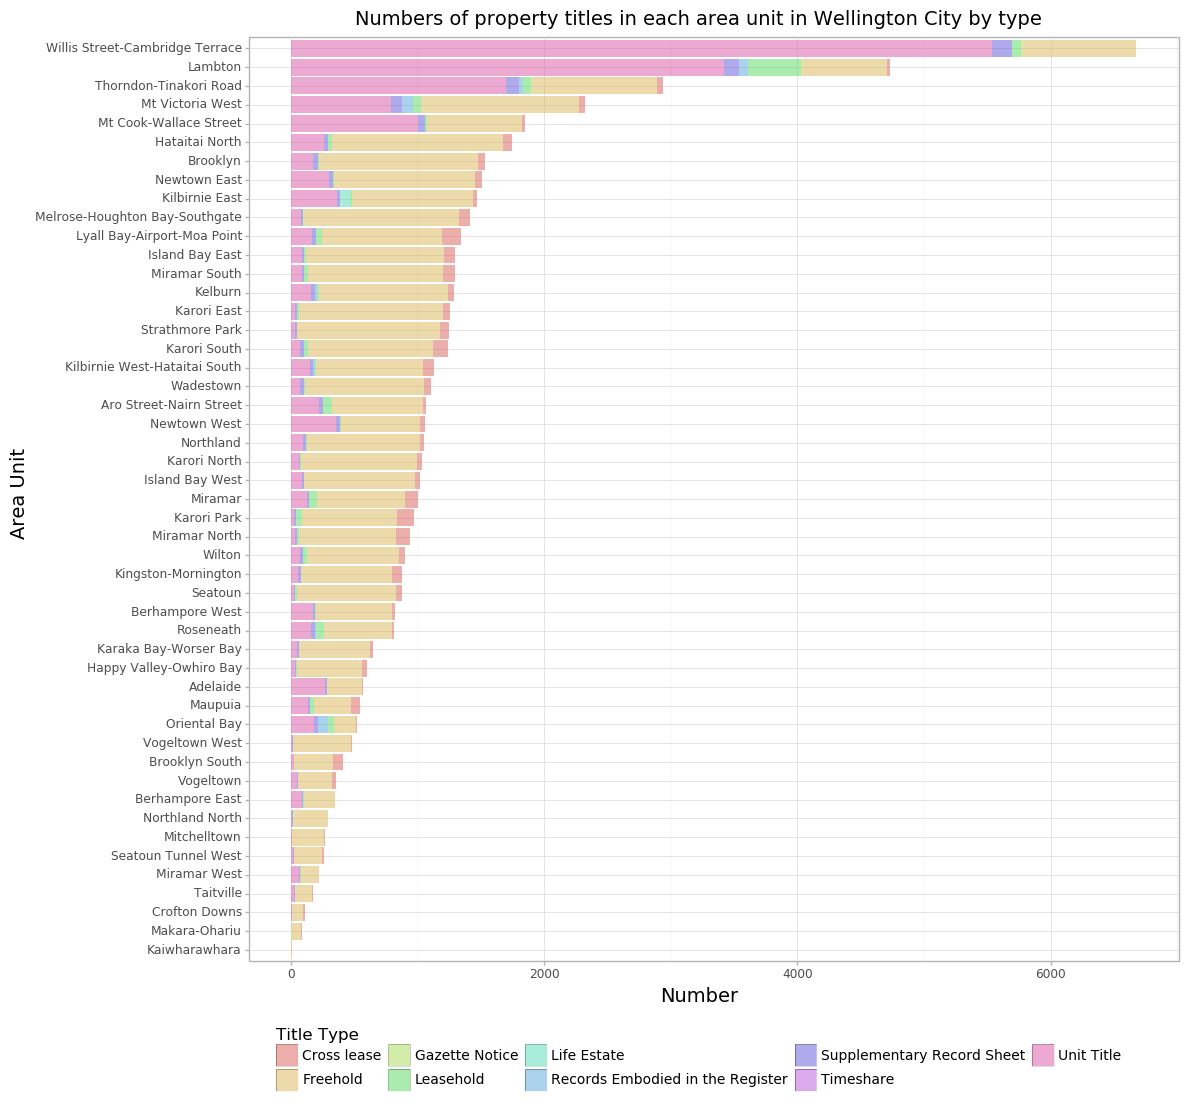

<ggplot: (164472863587)>

In [21]:
# Plot the property titles by area unit by type
(ggplot(property_with_au_df, aes('Area',fill='type')) 
 + geom_bar(alpha=0.5, position="stack")  
 + theme_light() 
 + scale_fill_discrete()
 + scale_x_discrete(limits = np.flip(area_unit_totals.Area.unique())) # orders the area units by largest to smallest
 + theme(title=element_text(size=14), figure_size=(12, 12), 
         legend_text=element_text(size=10), legend_title=element_text(size=12), legend_position=(.50, .03), 
         legend_direction='horizontal')
 + labs(x="Area Unit", y="Number", title="Numbers of property titles in each area unit in Wellington City by type",
       fill="Title Type")
 + coord_flip()
)

### 5.5 Is there a link between the median age of properties in an area unit and the number of rooms per property?
---
To explore the link between the median age that property titles were issued in an area unit, and the number of rooms per property, the scatter plot below was created.  It shows the relationpship between the median property title age and the number of properties in that area unit with under four rooms. Although a relatively crude measure, it does seem to show that the CBD and urban areas that have had lots of apartments added over the past twenty years have a higher proportion of properties with few rooms.  The more suburban areas that have had lots of housing development, such as Strathmore Park, Miramar West and Brooklyn appear to have very few properties with under four rooms. 

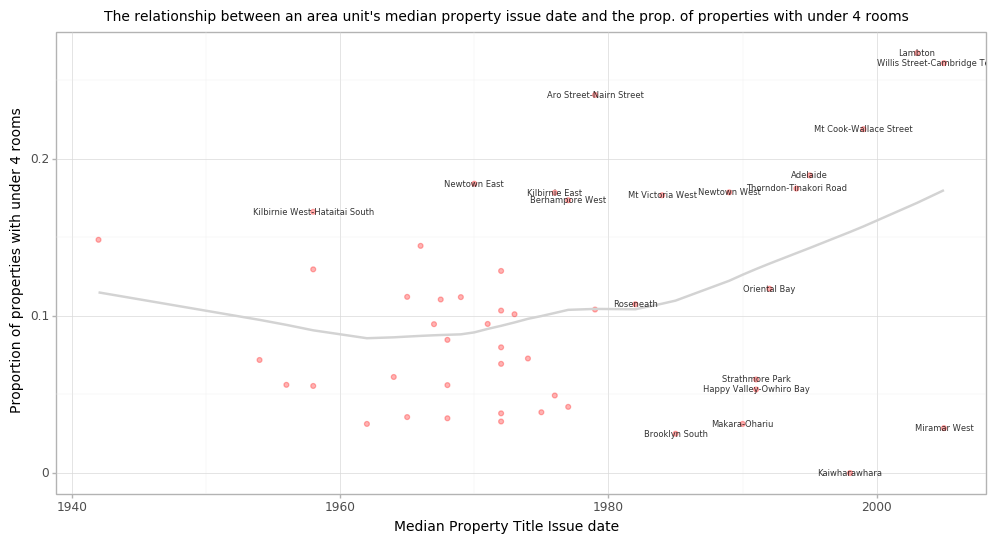

<ggplot: (164473693069)>

In [23]:
# Create a new variable to show the proportion of titles in the area unit with under four rooms
area_unit_totals_merged['prop_under_four_rooms'] = (area_unit_totals_merged['Two rooms'] + \
                                 area_unit_totals_merged['Three rooms'])/area_unit_totals_merged['Total dwellings stated']
area_unit_totals_merged

# Generate a scatter plot to show the relationship between area unit median property issue date and the prop of properties 
# with under 4 rooms.  
(ggplot(area_unit_totals_merged, aes('median_issue_year', 'prop_under_four_rooms')) 
 + geom_point(alpha=0.3, color='red') 
 + theme_light() 
 + scale_color_discrete(guide=False)
 + geom_smooth(color="lightgrey")
 + geom_text(aes(label='Area'), data=area_unit_totals_merged.query('prop_under_four_rooms>0.15|median_issue_year>1980'),size=6, nudge_y=0, alpha=0.8) 
  + theme(title=element_text(size=10), figure_size=(12, 6),
         legend_text=element_text(size=8), legend_title=element_text(size=8), legend_position="bottom")
 + labs(x="Median Property Title Issue date", y="Proportion of properties with under 4 rooms", 
        title="The relationship between an area unit's median property issue date and the prop. of properties with under 4 rooms")
)

## Section 6 - Conclusion
---
This analysis has shown that the property title data available from LINZ and the area unit boundary and 2013 census data from Stats NZ, are able to be combined to show a range of interesting historic information about how Wellington City has grown.  

It has also shown how geospatial data and map visualisations can easily be accessed and incorporated into a data analysis using widely used Pandas modules sucha as GeoPandas, Plotnine and Folium.  

## Appendix A - User-defined Functions 
---

In [3]:
# Function to download geoJSON layer data from the LINZ data service, and return it as a GeoDataFrame
def download_linz_data(api_key, layer_name, b_box, max_number = 100):
     
    # Create the URL as specified by the LINZ data service documentation at
    # https://www.linz.govt.nz/data/linz-data-service/guides-and-documentation/wfs-spatial-filtering     
    url = "https://data.linz.govt.nz/services;key=" + api_key + \
    "/wfs?service=WFS&version=2.0.0&request=GetFeature&typeNames=" + layer_name + \
    "&count=" + max_number + "&outputFormat=json" + "&cql_filter=bbox(shape," + b_box + ")"
    
    # Read the data from the url and return it
    df = geopandas.read_file(url)
    return df


# Function to download geoJSON layer data from the Stats Datafindinder service, and return it as a GeoDataFrame.
# Note the format is very similar to the LINZ Data Service but there are subtle differences to do with projections
# and column names.
def download_stats_boundaries(api_key, layer_name, b_box, max_number = 100):
     
    # Create the URL as specified by the Stats Datafinder documentation at https://datafinder.stats.govt.nz/     
    stats_url = "https://datafinder.stats.govt.nz/services;key=" + api_key + \
    "/wfs?service=WFS&version=2.0.0&request=GetFeature&typeNames=" + layer_name + \
    "&count=" + max_number + "&SRSName=urn:x-ogc:def:crs:EPSG:4326" + \
    "&outputFormat=json" + "&cql_filter=bbox(GEOMETRY," + b_box + ")"
    
    # Read the data from the url and return it
    stats_df = geopandas.read_file(stats_url)
    return stats_df



## Appendix B - References
---
The sources below are the references used during this analysis.  In particular, the Pandas, GeoPandas, Folium, and Plotnine package documentation were used extensively, as were the LINZ and Stats Datfinder documentation.  The Massey course material relating to saving SQL lite databases from Python was also used extensively (thanks!).   

* Folium 0.9.1 Documentation - Accessed at https://python-visualization.github.io/folium/
* Geonpandas 0.5.0 Documentation - Accessed at http://geopandas.org/index.html
* LINZ Property Title boundary layer - Accessed at https://data.linz.govt.nz/layer/50804-nz-property-titles/
* LINZ Guide to WFS spatial filtering - Accessed at https://www.linz.govt.nz/data/linz-data-service/guides-and-documentation/wfs-spatial-filtering
* Massey 'Intro to Analytics' Course Material, Tutorial and Lecture Notebooks - Accessed at https://stream.massey.ac.nz/course/view.php?id=40815 
* McKinney, Wes. (2017) 'Python for Data Analysis - Second Edition', O'Reilly
* Numpy Package Documentation Reference - Accessed at https://docs.scipy.org/doc/numpy-1.16.1/reference/index.html
* Pandas Package Documentation API and Reference - Accessed at https://pandas.pydata.org/pandas-docs/stable/reference/ 
* Plotnine Github Repository Issues Register - Accessed at https://github.com/has2k1/plotnine/issues
* Plotnine Package Documentation API and Tutorials - Accessed at https://plotnine.readthedocs.io/en/stable/index.html 
* Stats Area unit boundary layer - Accessed at https://datafinder.stats.govt.nz/layer/25743-area-unit-2013/
